In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy.core.defchararray as npchar
import pickle
import matplotlib.patches as mpatches

In [2]:
# set initial properties for data location
res = 40000
data_location = "matrices/"
true_location = "trueTADs/"
armatus_location = "./armatus"
out_location = "yielded/"
noise_values = [4, 8, 12, 16, 20]
sim_values = list(range(1, 6))
TAD_callers = ("lava_modularity", "lava_armatus")

In [84]:
# set range of gammas for methods
armatus_gamma = [i / 2 for i in range(11)]
modularity_gamma = list(range(101))
potts_gamma = list(range(41))
corner_gamma = [1,2]

In [4]:
# set plotting values
sns.set_palette(sns.color_palette("hls", 12))

In [5]:
# custom functions
vector_str = np.vectorize(str)

def TAD_bins(arr1, arr2):
    vector_str = np.vectorize(str)
    return npchar.add(vector_str(arr1), npchar.add(",", vector_str(arr2)))

def TAD_boundaries(arr1, arr2):
    return np.unique(np.append(arr1, arr2))

In [6]:
# load true TADs coordinates
true_TADs = pd.DataFrame(index=noise_values, columns=sim_values)
for noise in noise_values:
    for sim in sim_values:
        print(f"\rnoise={noise} sim={sim}", end="")
        true_TADs.loc[noise, sim] = np.loadtxt(f"{true_location}simHiC_TADintervals_coords_noise{noise}_sim{sim}.txt")
print("\nfinished")

noise=20 sim=5
finished


In [7]:
# combine true TADs coordinates into strings
true_TADs_bins = pd.DataFrame(index=noise_values, columns=sim_values)
for noise in noise_values:
    for sim in sim_values:
        true_TADs_bins.loc[noise, sim] = npchar.add(vector_str(true_TADs.loc[noise, sim][:, 0]), npchar.add(",", vector_str(true_TADs.loc[noise, sim][:, 1])))

In [8]:
# make unique true TADs boundaries
true_TADs_boundaries = pd.DataFrame(index=noise_values, columns=sim_values)
for noise in noise_values:
    for sim in sim_values:
        true_TADs_boundaries.loc[noise, sim] = np.unique(np.append(true_TADs.loc[noise, sim][:, 0], true_TADs.loc[noise, sim][:, 1]))

In [12]:
#TAD_stats = dict.fromkeys(("TPR_bins", "TPR_boundaries", "FDR_bins", "FDR_boundaries"))
stats = ("TPR_bins", "TPR_boundaries", "FDR_bins", "FDR_boundaries")
method_ranges = {"armatus":armatus_gamma, "lava_modularity":modularity_gamma, "lava_armatus":armatus_gamma}
TAD_stats = {stat:{method:{gamma:pd.DataFrame(index=noise_values, columns=sim_values) for gamma in method_ranges[method]} for method in TAD_callers} for stat in stats}

In [20]:
# count TPR and FDR for TADs
# TPR = TP / (TP + FN) = TP / observed_TADs
# FDR = FP / (TP + FP) = FP / true_TADs
for method in TAD_callers:
    for noise in noise_values:
        for sim in sim_values:
            for gamma in method_ranges[method]:
                print(f"\r method={method} noise={noise} sim={sim} gamma={gamma}", end="")
                TADs = np.loadtxt(f"{out_location}{method}_noise{noise}_sim{sim}_gamma{gamma}.txt", ndmin=2)
                bins = TAD_bins(TADs[:, 0], TADs[:, 1])
                boundaries = TAD_boundaries(TADs[:, 0], TADs[:, 1])
                TAD_stats["TPR_bins"][method][gamma].loc[noise, sim] = sum(np.isin(bins, true_TADs_bins.loc[noise, sim])) / true_TADs_bins.loc[noise, sim].shape[0]
                TAD_stats["FDR_bins"][method][gamma].loc[noise, sim] = sum(~np.isin(bins, true_TADs_bins.loc[noise, sim])) / bins.shape[0]
                TAD_stats["TPR_boundaries"][method][gamma].loc[noise, sim] = sum(np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / true_TADs_boundaries.loc[noise, sim].shape[0]
                TAD_stats["FDR_boundaries"][method][gamma].loc[noise, sim] = sum(~np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / boundaries.shape[0]

 method=lava_armatus noise=20 sim=5 gamma=5.0100

In [21]:
TAD_stats["TPR_bins"]["lava_modularity"]

{0:     1  2  3  4  5
 4   0  0  0  0  0
 8   0  0  0  0  0
 12  0  0  0  0  0
 16  0  0  0  0  0
 20  0  0  0  0  0, 1:     1  2  3  4  5
 4   0  0  0  0  0
 8   0  0  0  0  0
 12  0  0  0  0  0
 16  0  0  0  0  0
 20  0  0  0  0  0, 2:     1  2  3  4  5
 4   0  0  0  0  0
 8   0  0  0  0  0
 12  0  0  0  0  0
 16  0  0  0  0  0
 20  0  0  0  0  0, 3:              1  2  3  4  5
 4   0.00584795  0  0  0  0
 8            0  0  0  0  0
 12           0  0  0  0  0
 16           0  0  0  0  0
 20           0  0  0  0  0, 4:             1           2          3          4           5
 4   0.0643275   0.0877193  0.0877193  0.0526316   0.0701754
 8           0  0.00584795          0          0  0.00584795
 12          0           0          0          0           0
 16          0           0          0          0           0
 20          0           0          0          0           0, 5:              1           2          3          4           5
 4     0.309942    0.315789   0.204678    0.

In [34]:
# Initialize dataframe for plotting lava armatus stats
lava_armatus_stats = pd.DataFrame(index=range(len(noise_values) * len(sim_values) * len(armatus_gamma) * len(stats)), columns=list(("value", "stat", "noise", "sim", "gamma")))

In [35]:
# Fill lava_armatus_stats with values
item = 0   
for noise in noise_values:
    for sim in sim_values:
        for gamma in method_ranges["lava_armatus"]:
            for stat in stats:
                print(f"\ritem={item} noise={noise} sim={sim} gamma={gamma}", end="")
                lava_armatus_stats.loc[item, "value"] = TAD_stats[stat]["lava_armatus"][gamma].loc[noise, sim]
                #lava_armatus_stats.loc[item, "TPR_bins"] = TAD_stats["TPR_bins"]["lava_armatus"][gamma].loc[noise, sim]
                #lava_armatus_stats.loc[item, "FDR_bins"] = TAD_stats["FDR_bins"]["lava_armatus"][gamma].loc[noise, sim]
                #lava_armatus_stats.loc[item, "TPR_boundaries"] = TAD_stats["TPR_boundaries"]["lava_armatus"][gamma].loc[noise, sim]
                #lava_armatus_stats.loc[item, "FDR_boundaries"] = TAD_stats["FDR_boundaries"]["lava_armatus"][gamma].loc[noise, sim]
                lava_armatus_stats.loc[item, "stat":"gamma"] = [stat, noise, sim, gamma]
                item += 1

item=1099 noise=20 sim=5 gamma=5.0

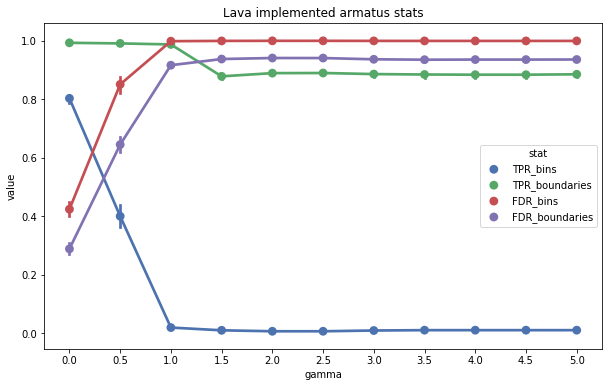

In [37]:
# Plot lava armatus stats
mpl.rcParams['figure.figsize'] = [10, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_armatus_stats, x="gamma", y="value", hue="stat")
plt.title("Lava implemented armatus stats")
plt.savefig("lava_armatus.png")

Hence, gamma=0 is the best one for lava implemented armatus

In [14]:
lava_modularity_stats = pd.DataFrame(index=range(len(noise_values) * len(sim_values) * len(modularity_gamma) * len(stats)), columns=list(("value", "stat", "noise", "sim", "gamma")))

In [22]:
# Fill lava_modularity_stats with values
item = 0   
for noise in noise_values:
    for sim in sim_values:
        for gamma in method_ranges["lava_modularity"]:
            for stat in stats:
                print(f"\ritem={item} noise={noise} sim={sim} gamma={gamma}", end="")
                lava_modularity_stats.loc[item, "value"] = TAD_stats[stat]["lava_modularity"][gamma].loc[noise, sim]
                lava_modularity_stats.loc[item, "stat":"gamma"] = [stat, noise, sim, gamma]
                item += 1

item=10099 noise=20 sim=5 gamma=100

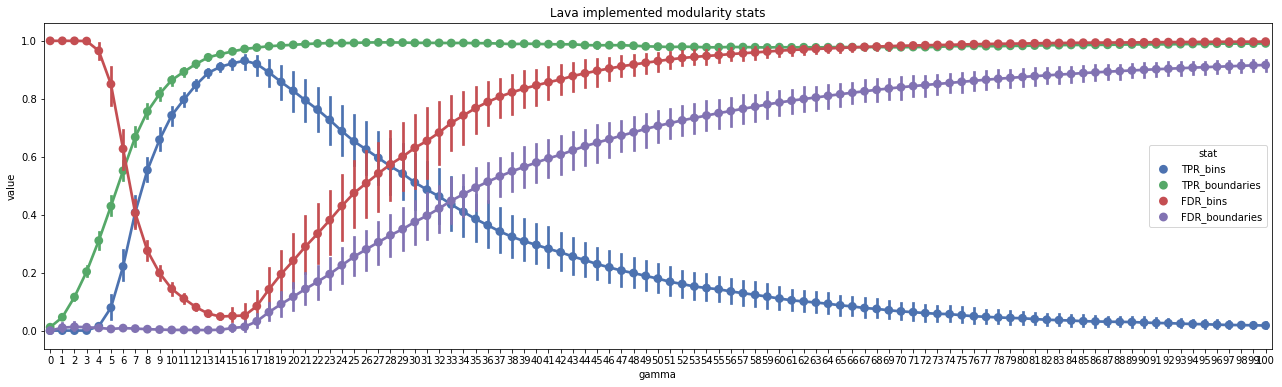

In [33]:
# Plot lava modularity stats
mpl.rcParams['figure.figsize'] = [22, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_modularity_stats, x="gamma", y="value", hue="stat")
plt.title("Lava implemented modularity stats")
plt.savefig("modularity.png")

The best gamma for modularity score is 15-16

In [62]:
#lava potts stats for the first file
lava_potts_stats = pd.DataFrame(index=range(len(noise_values) * len(sim_values) * len(potts_gamma) * len(stats)), columns=list(("value", "stat", "noise", "sim", "gamma")))
item = 0
for noise in noise_values:
    for sim in sim_values:
        for gamma in potts_gamma:
                print(f"\r method=lava_potts noise={noise} sim={sim} gamma={gamma}", end="")
                TADs = np.loadtxt(f"{out_location}lava_potts_noise{noise}_sim{sim}_gamma{gamma}.txt", ndmin=2)
                bins = TAD_bins(TADs[:, 0], TADs[:, 1])
                boundaries = TAD_boundaries(TADs[:, 0], TADs[:, 1])
                lava_potts_stats.loc[item, "value"] = sum(np.isin(bins, true_TADs_bins.loc[noise, sim])) / true_TADs_bins.loc[noise, sim].shape[0]
                lava_potts_stats.loc[item, "stat":"gamma"] = ["TPR_bins", noise, sim, gamma]
                item += 1
                lava_potts_stats.loc[item, "value"] = sum(~np.isin(bins, true_TADs_bins.loc[noise, sim])) / bins.shape[0]
                lava_potts_stats.loc[item, "stat":"gamma"] = ["FDR_bins", noise, sim, gamma]
                item += 1
                lava_potts_stats.loc[item, "value"] = sum(np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / true_TADs_boundaries.loc[noise, sim].shape[0]
                lava_potts_stats.loc[item, "stat":"gamma"] = ["TPR_boundaries", noise, sim, gamma]
                item += 1
                lava_potts_stats.loc[item, "value"] = sum(~np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / boundaries.shape[0]
                lava_potts_stats.loc[item, "stat":"gamma"] = ["FDR_boundaries", noise, sim, gamma]
                item += 1

 method=lava_potts noise=20 sim=5 gamma=40

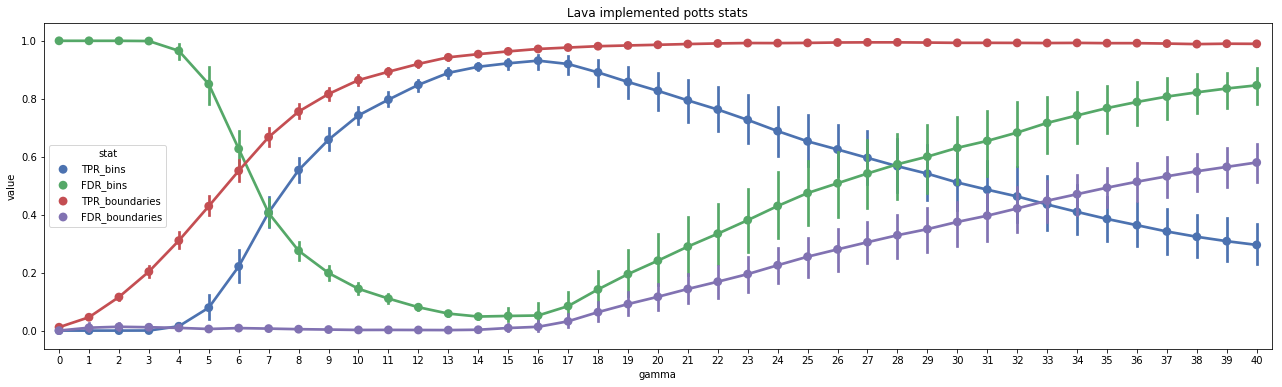

In [66]:
#lava potts stats for the first file
mpl.rcParams['figure.figsize'] = [22, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_potts_stats, x="gamma", y="value", hue="stat")
plt.title("Lava implemented potts stats")
plt.savefig("potts.png")

For potts the best gamma is 16

Text(0.5,1,'Lava implemented potts stats')

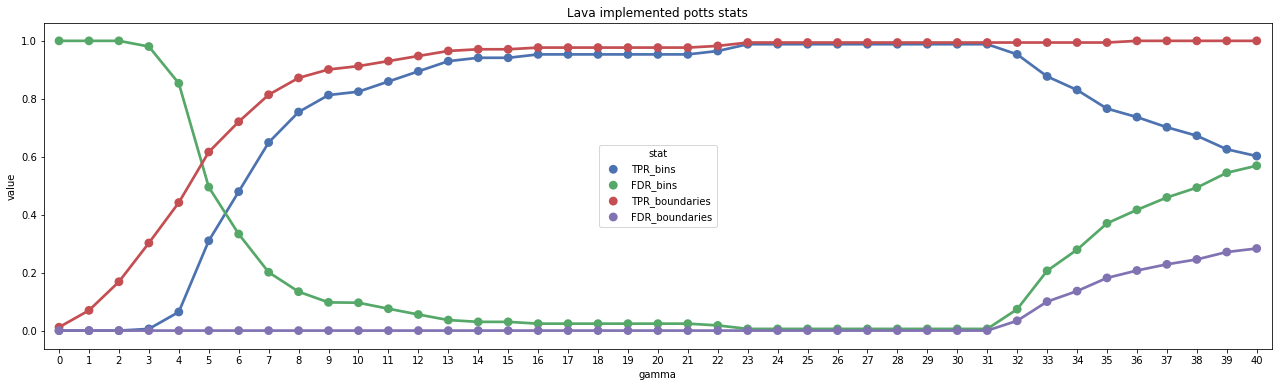

In [65]:
only_1 = lava_potts_stats["noise"] == 4
only_1 &= lava_potts_stats["sim"] == 1
#lava potts stats for the first file
mpl.rcParams['figure.figsize'] = [22, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_potts_stats[only_1], x="gamma", y="value", hue="stat")
plt.title("Lava implemented potts stats")
#plt.savefig("potts_1.png")

In [76]:
#lava variance stats for the first file
lava_variance_stats = pd.DataFrame(index=range(len(range(101)) * len(stats)), columns=list(("value", "stat", "noise", "sim", "gamma")))
item = 0
for noise in [4]:
    for sim in [1]:
        for gamma in range(101):
                print(f"\r method=lava_variance noise={noise} sim={sim} gamma={gamma}", end="")
                TADs = np.loadtxt(f"{out_location}lava_variance_noise{noise}_sim{sim}_gamma{gamma}.txt", ndmin=2)
                bins = TAD_bins(TADs[:, 0], TADs[:, 1])
                boundaries = TAD_boundaries(TADs[:, 0], TADs[:, 1])
                lava_variance_stats.loc[item, "value"] = sum(np.isin(bins, true_TADs_bins.loc[noise, sim])) / true_TADs_bins.loc[noise, sim].shape[0]
                lava_variance_stats.loc[item, "stat":"gamma"] = ["TPR_bins", noise, sim, gamma]
                item += 1
                lava_variance_stats.loc[item, "value"] = sum(~np.isin(bins, true_TADs_bins.loc[noise, sim])) / bins.shape[0]
                lava_variance_stats.loc[item, "stat":"gamma"] = ["FDR_bins", noise, sim, gamma]
                item += 1
                lava_variance_stats.loc[item, "value"] = sum(np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / true_TADs_boundaries.loc[noise, sim].shape[0]
                lava_variance_stats.loc[item, "stat":"gamma"] = ["TPR_boundaries", noise, sim, gamma]
                item += 1
                lava_variance_stats.loc[item, "value"] = sum(~np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / boundaries.shape[0]
                lava_variance_stats.loc[item, "stat":"gamma"] = ["FDR_boundaries", noise, sim, gamma]
                item += 1

 method=lava_variance noise=4 sim=1 gamma=100

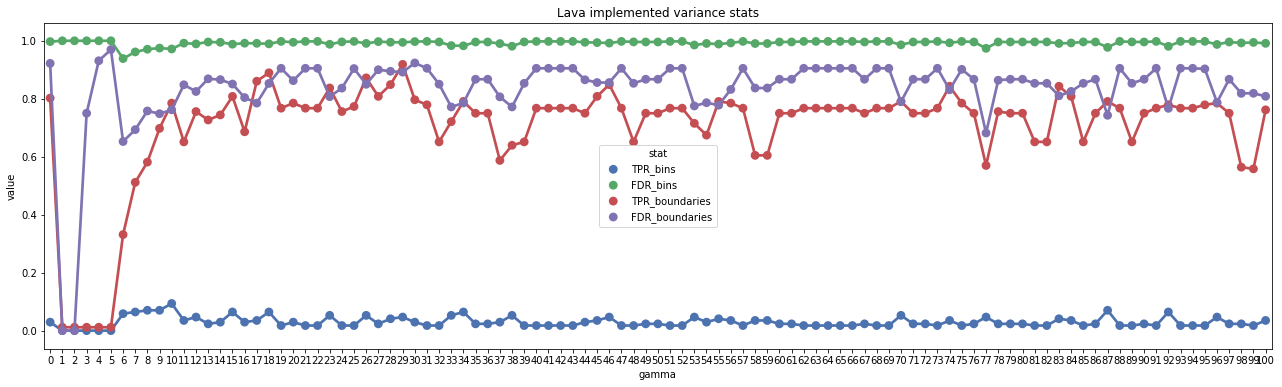

In [83]:
mpl.rcParams['figure.figsize'] = [22, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_variance_stats, x="gamma", y="value", hue="stat")
plt.title("Lava implemented variance stats")
plt.savefig("variance_1.png")

In [85]:
#lava corner stats for the first file
lava_corner_stats = pd.DataFrame(index=range(len(noise_values) * len(sim_values) * len(corner_gamma) * len(stats)), columns=list(("value", "stat", "noise", "sim", "gamma")))
item = 0
for noise in noise_values:
    for sim in sim_values:
        for gamma in corner_gamma:
                print(f"\r method=lava_variance noise={noise} sim={sim} gamma={gamma}", end="")
                TADs = np.loadtxt(f"{out_location}lava_corner_noise{noise}_sim{sim}_gamma{gamma}.txt", ndmin=2)
                bins = TAD_bins(TADs[:, 0], TADs[:, 1])
                boundaries = TAD_boundaries(TADs[:, 0], TADs[:, 1])
                lava_corner_stats.loc[item, "value"] = sum(np.isin(bins, true_TADs_bins.loc[noise, sim])) / true_TADs_bins.loc[noise, sim].shape[0]
                lava_corner_stats.loc[item, "stat":"gamma"] = ["TPR_bins", noise, sim, gamma]
                item += 1
                lava_corner_stats.loc[item, "value"] = sum(~np.isin(bins, true_TADs_bins.loc[noise, sim])) / bins.shape[0]
                lava_corner_stats.loc[item, "stat":"gamma"] = ["FDR_bins", noise, sim, gamma]
                item += 1
                lava_corner_stats.loc[item, "value"] = sum(np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / true_TADs_boundaries.loc[noise, sim].shape[0]
                lava_corner_stats.loc[item, "stat":"gamma"] = ["TPR_boundaries", noise, sim, gamma]
                item += 1
                lava_corner_stats.loc[item, "value"] = sum(~np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / boundaries.shape[0]
                lava_corner_stats.loc[item, "stat":"gamma"] = ["FDR_boundaries", noise, sim, gamma]
                item += 1

 method=lava_variance noise=20 sim=5 gamma=2

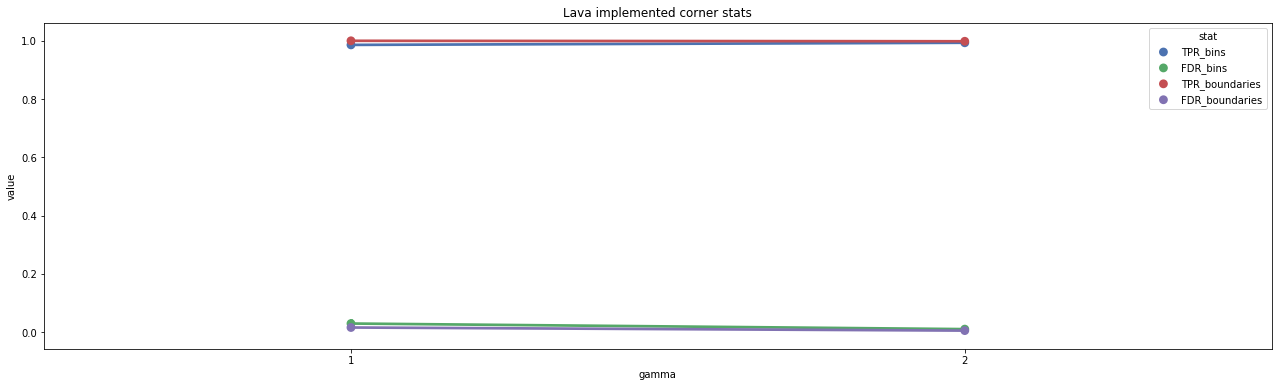

In [86]:
mpl.rcParams['figure.figsize'] = [22, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_corner_stats, x="gamma", y="value", hue="stat")
plt.title("Lava implemented corner stats")
plt.savefig("corner.png")

For corner, gamma=2 is the best.